# (Spatial+Pixel 증강) + CNN, epoch=200

In [1]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

2024-05-13 17:06:17.839532: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-13 17:06:17.936627: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


4 Physical GPUs, 4 Logical GPUs


2024-05-13 17:06:21.765739: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-13 17:06:23.457350: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5800 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:3b:00.0, compute capability: 7.5
2024-05-13 17:06:23.458424: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 12964 MB memory:  -> device: 1, name: Quadro RTX 5000, pci bus id: 0000:5e:00.0, compute capability: 7.5
2024-05-13 17:06:23.459318: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localh

In [1]:
import os

# 데이터셋의 루트 디렉토리
dataset_directory = '/home/jeonk636/ear_classification/eardrumDs'

# 클래스 이름 및 라벨을 매핑하기 위한 딕셔너리 생성
# normal:0, abnormal: 1
label_map = {
    'Aom': 1,
    'Chornic': 1,
    'Earwax': 1,
    'Normal': 0,
    'OtitExterna': 1,
    'tympanoskleros': 1
}

# 이미지 파일 경로 및 라벨을 저장할 리스트
image_paths = []
image_labels = []

# 제외 폴더
exclude_folders = {'Earventulation', 'Foreign', 'PseduoMembran'}

# 각 폴더에 대해 이미지 파일 경로 및 해당 라벨을 리스트에 추가
for label_folder in os.listdir(dataset_directory):
    if label_folder in exclude_folders:  # 이 폴더는 건너뛴다.
        continue
    folder_path = os.path.join(dataset_directory, label_folder)
    
    for image_filename in os.listdir(folder_path):
        # 폴더 내 파일이 실제 파일인지 확인하고 '.ipynb_checkpoints' 폴더를 건너뛴다.
        full_path = os.path.join(folder_path, image_filename)
        if os.path.isfile(full_path) and '.ipynb_checkpoints' not in full_path:
            image_paths.append(full_path)
            image_labels.append(label_map[label_folder])


In [3]:
# 라벨 0과 라벨 1의 개수를 계산.
label_0_count = image_labels.count(0)
label_1_count = image_labels.count(1)

(label_0_count, label_1_count)

(534, 391)

In [4]:
import numpy as np
from sklearn.model_selection import train_test_split

# 이미지 경로와 라벨을 Numpy 배열로 변환
image_paths = np.array(image_paths)
image_labels = np.array(image_labels)

# 전체 데이터를 훈련+검증 세트와 테스트 세트로 분할
x_train_all, x_test, y_train_all, y_test = train_test_split(
    image_paths, image_labels, stratify=image_labels, test_size=0.2, random_state=42)

# 훈련+검증 세트를 훈련 세트와 검증 세트로 분할
x_train, x_val, y_train, y_val = train_test_split(
    x_train_all, y_train_all, stratify=y_train_all, test_size=0.2, random_state=42)

In [5]:
# 결과 출력
print("Train set:", len(x_train))
print("Validation set:", len(x_val))
print("Test set:", len(x_test))

Train set: 592
Validation set: 148
Test set: 185


In [6]:
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import random

In [7]:
def flip_H(image):
    return tf.image.flip_left_right(image)

def flip_V(image):
    return tf.image.flip_up_down(image)

def rotate(image):
    angle = random.uniform(0, 360)
    rotated = tf.image.rot90(image, k=int(angle // 90))
    return rotated

In [8]:
def CLAHE(image):
    image = (image.numpy() * 255).astype(np.uint8)
    # RGB 채널을 BGR로 변경
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    # 각 채널에 CLAHE 적용
    channels = cv2.split(image)
    clahe = cv2.createCLAHE(clipLimit=4.0, tileGridSize=(8, 8)) #2.0
    clahed_channels = [clahe.apply(c) for c in channels]
    clahed_image = cv2.merge(clahed_channels)
    # 다시 RGB 채널로 변경
    clahed_image = cv2.cvtColor(clahed_image, cv2.COLOR_BGR2RGB)
    # 이미지를 [0, 1] 범위로 정규화
    clahed_image = clahed_image / 255.0
    return clahed_image
    
def Hue(image):
    hue_img = tf.image.adjust_hue(image, delta=0.1)
    hue_img = tf.image.adjust_saturation(hue_img, saturation_factor=1)
    return hue_img
    # delta = random.uniform(-0.5, 0.5)
    # return tf.image.adjust_hue(image, delta=delta)

def RandomContrast(image):
    # contrast_image = tf.image.random_contrast(image, lower=1.0, upper=3.0)
    # contrast_image = tf.clip_by_value(contrast_image, 0.0, 1.0)  # 클리핑
    # return contrast_image
    lower, upper = 0.75, 1.25  # 대비 범위 변경
    return tf.image.random_contrast(image, lower=lower, upper=upper)

def RandomBrightness(image):
    bright_image = tf.image.random_brightness(image, max_delta=0.3)
    bright_image = tf.clip_by_value(bright_image, 0.0, 1.0)  # 클리핑
    return bright_image

def Blur(image):
    image = image.numpy()
    # blur_img = cv2.blur(image, (5, 5))
    # return blur_img
    kernel_size = random.choice([(5, 5), (7, 7), (9, 9), (13,13)])
    return cv2.blur(image, kernel_size)


In [9]:
normal_indices = [i for i, label in enumerate(y_train) if label == 0] 
abnormal_indices = [j for j, label in enumerate(y_train) if label == 1] 

selected_normal_images = [(x_train[i]) for i in normal_indices] 
selected_normal_indexs = [(y_train[i]) for i in normal_indices]
selected_abnormal_images = [(x_train[j]) for j in abnormal_indices]
selected_abnormal_indexs = [(y_train[j]) for j in abnormal_indices]

In [10]:
def load_and_preprocess_image(path, target_size=(250, 250)):
    # 이미지를 RGB로 변환하여 로드
    image = Image.open(path).convert('RGB')
    image = image.resize(target_size)  # 목표 크기로 리사이징
    image = np.array(image)  # 이미지를 numpy 배열로 변환
    image = tf.convert_to_tensor(image, dtype=tf.float32) / 255.0  # 텐서로 변환하고 정규화
    return image

In [11]:
aug_func_spatial = {
    'flip_H': flip_H,
    'flip_V': flip_V,
    'rotate': rotate
}

aug_ratio_spatial = {
    'flip_H': 0.3,
    'flip_V': 0.3,
    'rotate': 0.4
}

aug_func_pixel = {
    'CLAHE': CLAHE,
    #'Hue': Hue,
    'RandomContrast': RandomContrast,
    'RandomBrightness': RandomBrightness,
    'Blur': Blur
}

aug_ratio_pixel = {
    'CLAHE': 0.2,
    #'Hue': 0.1,
    'RandomContrast': 0.2,
    'RandomBrightness': 0.3,
    'Blur': 0.3
}

def apply_aug_spatial(images, augmentations, ratios):
    augmented_images = []
    func_names = list(augmentations.keys())  # 사전의 키를 리스트로 변환
    probabilities = [ratios[name] for name in func_names]  # 확률 추출
    aug_choice = np.random.choice(func_names, p=probabilities)  # 확률에 따라 선택
    augmented_image = aug_func_spatial[aug_choice](images)  # 증강 함수 적용
    augmented_images.append(augmented_image)
    return augmented_images

def apply_aug_pixel(images, augmentations, ratios):
    augmented_images = []
    func_names = list(augmentations.keys()) 
    probabilities = [ratios[name] for name in func_names]
    aug_choice = np.random.choice(func_names, p=probabilities) 
    augmented_image = aug_func_pixel[aug_choice](images)
    augmented_images.append(augmented_image)
    return augmented_images


In [12]:
def apply_multiple_augmentations(image, aug_func_spatial, aug_ratio_spatial, aug_func_pixel, aug_ratio_pixel):
    # 공간적 증강(spatial augmentation)을 먼저 적용
    spatial_funcs = list(aug_func_spatial.keys())
    spatial_probs = [aug_ratio_spatial[name] for name in spatial_funcs]
    spatial_choice = np.random.choice(spatial_funcs, p=spatial_probs)
    image = aug_func_spatial[spatial_choice](image)

    # 픽셀 기반 증강(pixel-based augmentation)을 적용
    pixel_funcs = list(aug_func_pixel.keys())
    pixel_probs = [aug_ratio_pixel[name] for name in pixel_funcs]
    pixel_choice = np.random.choice(pixel_funcs, p=pixel_probs)
    image = aug_func_pixel[pixel_choice](image)

    return image

In [13]:
random_select_normal = random.choices(selected_normal_images, k=658)

aug_normal = []
for image in random_select_normal:
    tensor = load_and_preprocess_image(image)  # RGB를 array로 변환
    augmented_image = apply_multiple_augmentations(tensor, aug_func_spatial, aug_ratio_spatial, aug_func_pixel, aug_ratio_pixel)
    aug_normal.append(augmented_image)

aug_normal_label = [0]*658

In [14]:
print(len(random_select_normal))
print(len(aug_normal))
print(len(aug_normal_label))

658
658
658


In [15]:
random_select_abnormal = random.choices(selected_abnormal_images, k=750)

aug_abnormal = []
for image in random_select_abnormal:
    tensor = load_and_preprocess_image(image)
    aug_abnormal.append(apply_multiple_augmentations(tensor, aug_func_spatial, aug_ratio_spatial, aug_func_pixel, aug_ratio_pixel))
    
aug_abnormal_label = [1]*750

In [16]:
print(len(aug_abnormal))
print(len(aug_abnormal_label))

750
750


In [17]:
x_train = [load_and_preprocess_image(path) for path in x_train]
x_val = [load_and_preprocess_image(path) for path in x_val]
x_test = [load_and_preprocess_image(path) for path in x_test]

In [18]:
# NumPy 배열로 변환 (필요한 경우)
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

aug_normal_label = np.array(aug_normal_label)
aug_abnormal_label = np.array(aug_abnormal_label)

def resize_image(image, target_size=(250, 250)):
    return tf.image.resize(image, target_size)
    
aug_normal_resized = [resize_image(img) for img in aug_normal]
aug_abnormal_resized = [resize_image(img) for img in aug_abnormal]

x_train_resized = [resize_image(img) for img in x_train]

new_y_train = np.concatenate([y_train, aug_normal_label, aug_abnormal_label])

new_x_train = x_train_resized + aug_normal_resized + aug_abnormal_resized

print(len(new_x_train)) 
print(len(new_y_train))

2000
2000


In [19]:
new_x_train = tf.stack(new_x_train) 
x_val = tf.stack(x_val)
x_test = tf.stack(x_test)

In [20]:
print("new_x_train 길이:", len(new_x_train))
print("new_y_train 길이:", len(new_y_train))
print("x_val 길이:", len(x_val))
print("y_val 길이:", len(y_val))
print("x_test 길이:", len(x_test))
print("y_test 길이:", len(y_test))

new_x_train 길이: 2000
new_y_train 길이: 2000
x_val 길이: 148
y_val 길이: 148
x_test 길이: 185
y_test 길이: 185


In [41]:
from keras.callbacks import EarlyStopping

logical_gpus = tf.config.experimental.list_logical_devices ('GPU')
strategy = tf.distribute.MirroredStrategy(logical_gpus)

#with tf.device("/gpu:0"):
with strategy.scope():
    model = tf.keras.Sequential([
        # 첫 번째 컨볼루션 레이어
        tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(250, 250, 3)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.25),

        # 두 번째 컨볼루션 레이어
        tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.25),

        # 세 번째 컨볼루션 레이어
        tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.25),

        # Flatten 후 밀집층
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(2, activation='softmax')
    ])

    # 모델 컴파일
    model.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',  # from_logits=True 제거
                metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_acc', patience=20)
# Train
history = model.fit(new_x_train, new_y_train, epochs=200, validation_data=(x_val, y_val), callbacks=[early_stopping])
#history = model.fit(new_x_train, new_y_train, epochs=100, validation_data=(x_val, y_val))

# Evaluate
test_loss, test_acc = model.evaluate(x_test, y_test)
print('Test accuracy:', test_acc)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task

2024-05-13 17:08:35.804596: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-05-13 17:08:38.073646: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8907
2024-05-13 17:08:38.937065: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8907
2024-05-13 17:08:39.865194: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8907
2024-05-13 17:08:40.282128: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-05-13 17:08:40.286001: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect 

63/63 [==============================] - 23s 104ms/step - loss: 1.0158 - accuracy: 0.6090 - val_loss: 1.7056 - val_accuracy: 0.5608
Epoch 2/200
63/63 [==============================] - 5s 72ms/step - loss: 0.8425 - accuracy: 0.6130 - val_loss: 1.6574 - val_accuracy: 0.6149
Epoch 3/200
63/63 [==============================] - 4s 59ms/step - loss: 0.7687 - accuracy: 0.6325 - val_loss: 0.8371 - val_accuracy: 0.5743
Epoch 4/200
63/63 [==============================] - 4s 58ms/step - loss: 0.7390 - accuracy: 0.6310 - val_loss: 0.9968 - val_accuracy: 0.5743
Epoch 5/200
63/63 [==============================] - 4s 59ms/step - loss: 0.7043 - accuracy: 0.6120 - val_loss: 0.6939 - val_accuracy: 0.4932
Epoch 6/200
63/63 [==============================] - 4s 66ms/step - loss: 0.6566 - accuracy: 0.6470 - val_loss: 0.7122 - val_accuracy: 0.4865
Epoch 7/200
63/63 [==============================] - 4s 70ms/step - loss: 0.6413 - accuracy: 0.6615 - val_loss: 0.7076 - val_accuracy: 0.5203
Epoch 8/200
63/6

In [42]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 250, 250, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 250, 250, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 125, 125, 32)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 125, 125, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 batch_normalization_1 (Batc  (None, 125, 125, 64)     2

5/5 - 0s - loss: 0.5822 - accuracy: 0.7432 - 248ms/epoch - 50ms/step


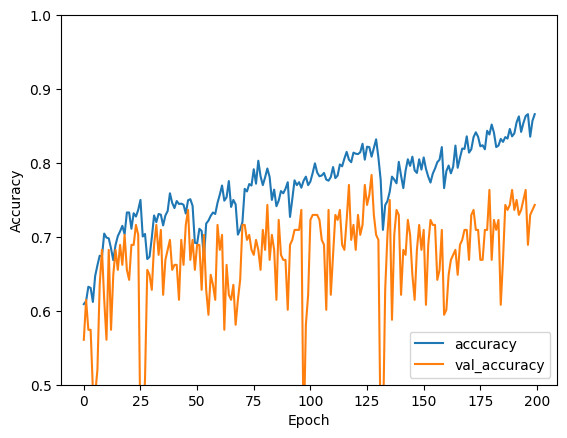

In [43]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(x_val,  y_val, verbose=2)

## spatial + pixel 증강 적용 예시

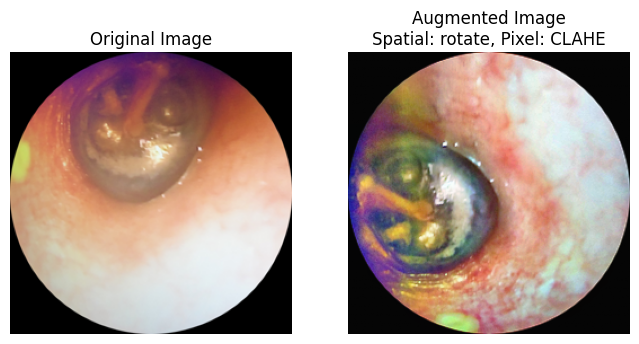

In [40]:
import matplotlib.pyplot as plt
import numpy as np

def show_images(original, augmented, augmentation_details):
    # 원본 및 증강된 이미지를 화면에 표시
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    # 이미지 정규화 체크 및 조정
    if np.max(original) > 1.0:
        original = original / 255.0
    plt.imshow(original)
    plt.title('Original Image')
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    if np.max(augmented) > 1.0:
        augmented = augmented / 255.0
    plt.imshow(augmented)
    plt.title(f'Augmented Image\n{augmentation_details}')
    plt.axis('off')
    
    plt.show()

# 이미지 로드 및 증강 함수 호출은 기존의 방식을 그대로 유지
import random
ex_path = random.choice(x_train_all)  # 무작위 이미지 경로 선택
image2 = load_and_preprocess_image(ex_path)

# 이미지에 다양한 증강 적용
augmented_image, aug_names = apply_multiple_augmentations(
    image2, aug_func_spatial, aug_ratio_spatial, aug_func_pixel, aug_ratio_pixel
)

# 수정된 show_images 함수를 사용하여 이미지 시각화
show_images(image2, augmented_image, aug_names)

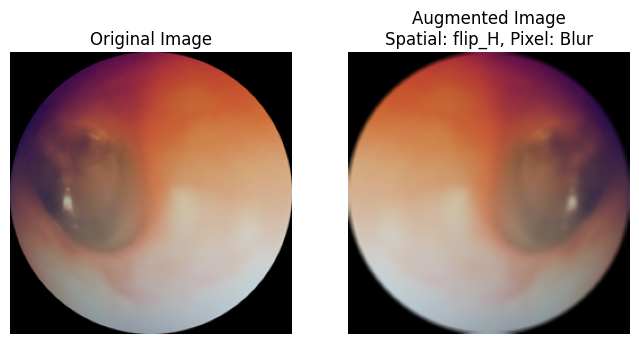

In [22]:
import random
ex_path = random.choice(x_train_all)  # 예시 이미지 경로
image2 = load_and_preprocess_image(ex_path)

def apply_multiple_augmentations(image, aug_func_spatial, aug_ratio_spatial, aug_func_pixel, aug_ratio_pixel):
    # 공간적 증강(spatial augmentation)을 먼저 적용
    spatial_funcs = list(aug_func_spatial.keys())
    spatial_probs = [aug_ratio_spatial[name] for name in spatial_funcs]
    spatial_choice = np.random.choice(spatial_funcs, p=spatial_probs)
    image = aug_func_spatial[spatial_choice](image)

    # 픽셀 기반 증강(pixel-based augmentation)을 적용
    pixel_funcs = list(aug_func_pixel.keys())
    pixel_probs = [aug_ratio_pixel[name] for name in pixel_funcs]
    pixel_choice = np.random.choice(pixel_funcs, p=pixel_probs)
    image = aug_func_pixel[pixel_choice](image)

    # 적용된 증강 함수의 이름 반환
    return image, f"Spatial: {spatial_choice}, Pixel: {pixel_choice}"

# 예제 이미지에 두 증강을 적용
augmented_image, aug_names = apply_multiple_augmentations(image2, aug_func_spatial, aug_ratio_spatial, aug_func_pixel, aug_ratio_pixel)

def show_images(original, augmented, augmentation_details):
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(original)
    plt.title('Original Image')
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(augmented)
    plt.title(f'Augmented Image\n{augmentation_details}')
    plt.axis('off')
    
    plt.show()

# 시각화 실행
show_images(image2, augmented_image, aug_names)